In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import linalg, optimize, sparse
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean Data

In [2]:
df = pd.read_csv('twitter_data(all).csv')
df.head()

,Date,ID,Name,Text,Hashtags,User Mentions,Symbols,Media,Source,Location,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries
0,2021-03-22 10:46:46,1373949268164153345,YouTube,@StarlightWarm and beautiful 🌹,NaN,Don't touch my tea,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,0.0,0.0,32085.0,Tech Company
1,2021-03-22 10:46:32,1373949209187995652,YouTube,@TheeAngryWalnut Spreading love everywhere!,NaN,😤 THEE ANGRY WALNUT IS HERE😤,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,2.0,0.0,32085.0,Tech Company
2,2021-03-22 10:46:05,1373949093886582784,YouTube,@Maeliosa8 💕💕,NaN,Maeliosa,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,0.0,0.0,32085.0,Tech Company
3,2021-03-22 06:00:04,1373877114743705602,YouTube,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,NaN,Sprinklr,"San Bruno, CA",73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company
4,2021-03-21 19:38:33,1373720706689638401,YouTube,@LindseyMarsland Relatable https://t.co/FaSUCg...,NaN,Lindsey Marsland (she/her),NaN,http://pbs.twimg.com/tweet_video_thumb/ExBvsHI...,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,3.0,0.0,32085.0,Tech Company


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['ID'] = df['ID'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16086 entries, 0 to 16085
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            16086 non-null  datetime64[ns]
 1   ID              16086 non-null  object        
 2   Name            16086 non-null  object        
 3   Text            16086 non-null  object        
 4   Hashtags        3474 non-null   object        
 5   User Mentions   8378 non-null   object        
 6   Symbols         15 non-null     object        
 7   Media           2643 non-null   object        
 8   Source          16086 non-null  object        
 9   Location        11390 non-null  object        
 10  Follower count  16086 non-null  float64       
 11  Friends count   16086 non-null  float64       
 12  Favorite count  16086 non-null  float64       
 13  Retweet count   16086 non-null  float64       
 14  Status count    16086 non-null  float64       
 15  In

In [4]:
# Filter out reply tweets
data = df.loc[~((df.Text.str.match('@.+\s')) & (df['Favorite count'] < 10) & (df['Retweet count'] < 10))]
data.reset_index(inplace=True, drop=True)
data

,Date,ID,Name,Text,Hashtags,User Mentions,Symbols,Media,Source,Location,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries
0,2021-03-22 06:00:04,1373877114743705602,YouTube,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,NaN,Sprinklr,"San Bruno, CA",73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company
1,2021-03-21 13:55:36,1373634398919262210,YouTube,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company
2,2021-03-21 11:00:01,1373590213818212352,YouTube,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,NaN,Sprinklr,"San Bruno, CA",73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company
3,2021-03-20 23:54:48,1373422805199458305,YouTube,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,71.0,18.0,32085.0,Tech Company
4,2021-03-20 23:31:40,1373416985439047681,YouTube,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,NaN,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,15.0,0.0,32085.0,Tech Company
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,1256056403715735554,Gal Gadot,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor
12597,2020-05-01 02:32:38,1256048857625976834,Gal Gadot,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor
12598,2020-05-01 02:31:38,1256048604088688640,Gal Gadot,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor
12599,2020-04-22 22:30:54,1253088919354134528,Gal Gadot,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12601 entries, 0 to 12600
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            12601 non-null  datetime64[ns]
 1   ID              12601 non-null  object        
 2   Name            12601 non-null  object        
 3   Text            12601 non-null  object        
 4   Hashtags        3361 non-null   object        
 5   User Mentions   4920 non-null   object        
 6   Symbols         8 non-null      object        
 7   Media           2561 non-null   object        
 8   Source          12601 non-null  object        
 9   Location        8600 non-null   object        
 10  Follower count  12601 non-null  float64       
 11  Friends count   12601 non-null  float64       
 12  Favorite count  12601 non-null  float64       
 13  Retweet count   12601 non-null  float64       
 14  Status count    12601 non-null  float64       
 15  In

In [6]:
data.describe()

,Follower count,Friends count,Favorite count,Retweet count,Status count
count,1.260100e+04,12601.000000,1.260100e+04,12601.000000,12601.000000
mean,3.104978e+07,40614.772796,2.085477e+04,3405.064201,87668.160622
std,3.305299e+07,109115.593097,9.134023e+04,17886.001187,136767.698340
min,2.900000e+01,0.000000,0.000000e+00,0.000000,2.000000
25%,4.933877e+06,130.000000,4.000000e+00,10.000000,10526.000000
50%,1.803052e+07,724.000000,3.100000e+02,97.000000,22643.000000
75%,5.187557e+07,12932.000000,4.936000e+03,1338.000000,87391.000000
max,1.300607e+08,593779.000000,4.212155e+06,810444.000000,667452.000000


array([[<AxesSubplot:title={'center':'Follower count'}>,
        <AxesSubplot:title={'center':'Friends count'}>],
       [<AxesSubplot:title={'center':'Favorite count'}>,
        <AxesSubplot:title={'center':'Retweet count'}>],
       [<AxesSubplot:title={'center':'Status count'}>, <AxesSubplot:>]],
      dtype=object)

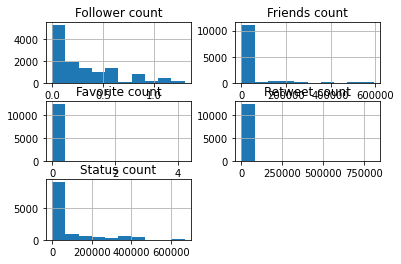

In [7]:
data.hist()

# Features Extraction

In [8]:
# create target
df1 = data.copy()
df1['Engagement'] = df1['Retweet count'] + df1['Favorite count']
df1
df1['Engagement_class'] = np.where((df1['Engagement']> df1['Engagement'].median()), 1, 0)

# Drop unnecessary columns
df1.drop(columns = ['Location', 'Source', 'Symbols', 'ID', 'Name', 'Retweet count', 'Favorite count'], 
         inplace=True)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Status count,Industries,Engagement,Engagement_class
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1499.0,1
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,32085.0,Tech Company,6931.0,1
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1712.0,1
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,32085.0,Tech Company,89.0,0
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,32085.0,Tech Company,15.0,0
...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1758.0,Actor,1188.0,1
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,1758.0,Actor,532.0,0
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,1758.0,Actor,5272.0,1
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,1758.0,Actor,18672.0,1


In [9]:
df1[df1['Engagement_class'] == 1] 

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Status count,Industries,Engagement,Engagement_class
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1499.0,1
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,32085.0,Tech Company,6931.0,1
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1712.0,1
5,2021-03-20 20:00:00,If\n\n you\n\n always\n\n Watch Later\n\nwhat...,WorldPoetryDay,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,5027.0,1
8,2021-03-20 10:59:57,"Queen of hair tutorials, @aidakiraya can teach...",NaN,Aida K,NaN,73105218.0,1202.0,32085.0,Tech Company,1316.0,1
...,...,...,...,...,...,...,...,...,...,...,...
12595,2020-05-01 03:03:00,@PedroPascal1 You always make me happy! I love...,NaN,Pedro Pascal he/him,NaN,2708999.0,169.0,1758.0,Actor,1484.0,1
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1758.0,Actor,1188.0,1
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,1758.0,Actor,5272.0,1
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,1758.0,Actor,18672.0,1


In [10]:
# Extract time and day of week from Date column

def greeting(hours):
    if hours in range(5,12):
        h = 'morning'
    elif hours in range(12,18):
        h = 'afternoon'
    elif hours in range(18,21):
        h = 'evening'
    else:
        h = 'night'
    return h

def name_the_day(day):
    if day == 0:
        return "Monday"
    elif day == 1:
        return "Tuesday"
    elif day == 2:
        return "Wednesday"
    elif day == 3:
        return "Thursday"
    elif day == 4:
        return "Friday"
    elif day == 5:
        return "Saturday"
    else:
        return "Sunday"
    

df1['Time'] = data['Date'].dt.hour.apply(greeting)
df1['Day of Weeks'] = data['Date'].dt.dayofweek.apply(name_the_day)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Status count,Industries,Engagement,Engagement_class,Time,Day of Weeks
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1499.0,1,morning,Monday
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,32085.0,Tech Company,6931.0,1,afternoon,Sunday
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1712.0,1,morning,Sunday
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,32085.0,Tech Company,89.0,0,night,Saturday
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,32085.0,Tech Company,15.0,0,night,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1758.0,Actor,1188.0,1,night,Friday
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,1758.0,Actor,532.0,0,night,Friday
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,1758.0,Actor,5272.0,1,night,Friday
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,1758.0,Actor,18672.0,1,night,Wednesday


In [11]:
# Create Hashtag Count and length

def hashtags_count(hashs):
    if pd.notna(hashs) :
        hashs = str(hashs)
        hashs = hashs.split(',')
        counts = len(hashs)
    else:
        counts = 0
    return counts

def length_h(hashs):
    if pd.notna(hashs):
        hashs = str(hashs).replace(',','')
        count = len(list(hashs))
        return count
    else:
        return 0

df1['hashtags_count'] = df1.Hashtags.apply(hashtags_count)
df1['length_hashtag'] = df1.Hashtags.apply(length_h)

df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Status count,Industries,Engagement,Engagement_class,Time,Day of Weeks,hashtags_count,length_hashtag
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1499.0,1,morning,Monday,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,32085.0,Tech Company,6931.0,1,afternoon,Sunday,0,0
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1712.0,1,morning,Sunday,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,32085.0,Tech Company,89.0,0,night,Saturday,1,8
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,32085.0,Tech Company,15.0,0,night,Saturday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1758.0,Actor,1188.0,1,night,Friday,0,0
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,1758.0,Actor,532.0,0,night,Friday,0,0
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,1758.0,Actor,5272.0,1,night,Friday,0,0
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,1758.0,Actor,18672.0,1,night,Wednesday,1,8


In [12]:
# Create user_mention Count

def mention_count(x):
    if pd.notna(x):
        x = str(x)
        x = x.split(',')
        counts = len(x)
    else:
        counts = 0
    return counts

df1['user_mentions_count'] = df1['User Mentions'].apply(mention_count)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Status count,Industries,Engagement,Engagement_class,Time,Day of Weeks,hashtags_count,length_hashtag,user_mentions_count
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1499.0,1,morning,Monday,0,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,32085.0,Tech Company,6931.0,1,afternoon,Sunday,0,0,1
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1712.0,1,morning,Sunday,0,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,32085.0,Tech Company,89.0,0,night,Saturday,1,8,6
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,32085.0,Tech Company,15.0,0,night,Saturday,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1758.0,Actor,1188.0,1,night,Friday,0,0,5
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,1758.0,Actor,532.0,0,night,Friday,0,0,1
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,1758.0,Actor,5272.0,1,night,Friday,0,0,1
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,1758.0,Actor,18672.0,1,night,Wednesday,1,8,0


In [14]:
# Dummy if media exist
def media(x):
    if pd.notna(x):
        return 1
    else:
        return 0

df1['media'] = df1['Media'].apply(media)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Status count,Industries,Engagement,Engagement_class,Time,Day of Weeks,hashtags_count,length_hashtag,user_mentions_count,media
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1499.0,1,morning,Monday,0,0,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,32085.0,Tech Company,6931.0,1,afternoon,Sunday,0,0,1,0
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,32085.0,Tech Company,1712.0,1,morning,Sunday,0,0,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,32085.0,Tech Company,89.0,0,night,Saturday,1,8,6,0
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,32085.0,Tech Company,15.0,0,night,Saturday,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1758.0,Actor,1188.0,1,night,Friday,0,0,5,0
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,1758.0,Actor,532.0,0,night,Friday,0,0,1,0
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,1758.0,Actor,5272.0,1,night,Friday,0,0,1,0
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,1758.0,Actor,18672.0,1,night,Wednesday,1,8,0,0


# Dummy Industries, Time and Day of Weeks
df1 = pd.get_dummies(df1, columns=['Industries', 'Time', 'Day of Weeks'])
df1

In [15]:
df1.drop(columns=['Hashtags','Status count'], inplace=True)

In [16]:
df1.drop(columns=['Date','User Mentions','Media','Engagement_class'], inplace=True)
df1

,Text,Follower count,Friends count,Industries,Engagement,Time,Day of Weeks,hashtags_count,length_hashtag,user_mentions_count,media
0,💞 The adventures of Natsumi and Haru! These si...,73105218.0,1202.0,Tech Company,1499.0,morning,Monday,0,0,0,0
1,"@MKBHD 10/10, would sign up again 🏆",73105218.0,1202.0,Tech Company,6931.0,afternoon,Sunday,0,0,1,0
2,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,73105218.0,1202.0,Tech Company,1712.0,morning,Sunday,0,0,0,0
3,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,73105218.0,1202.0,Tech Company,89.0,night,Saturday,1,8,6,0
4,@VoytekPavlik https://t.co/WFAwYTuXoZ,73105218.0,1202.0,Tech Company,15.0,night,Saturday,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
12596,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,2708999.0,169.0,Actor,1188.0,night,Friday,0,0,5,0
12597,@GDIGM Thank you legend!! Sending much love yo...,2708999.0,169.0,Actor,532.0,night,Friday,0,0,1,0
12598,@PattyJenks Jenkins !!!! I love you so much!! ...,2708999.0,169.0,Actor,5272.0,night,Friday,0,0,1,0
12599,I’m so moved seeing everyones images of earth ...,2708999.0,169.0,Actor,18672.0,night,Wednesday,1,8,0,0


In [17]:
df1.columns

Index(['Text', 'Follower count', 'Friends count', 'Industries', 'Engagement',
       'Time', 'Day of Weeks', 'hashtags_count', 'length_hashtag',
       'user_mentions_count', 'media'],
      dtype='object')

In [20]:
df1

,Text,Follower count,Friends count,Industries,Engagement,Time,Day of Weeks,hashtags_count,length_hashtag,user_mentions_count,media
0,💞 The adventures of Natsumi and Haru! These si...,73105218.0,1202.0,Tech Company,1499.0,morning,Monday,0,0,0,0
1,"@MKBHD 10/10, would sign up again 🏆",73105218.0,1202.0,Tech Company,6931.0,afternoon,Sunday,0,0,1,0
2,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,73105218.0,1202.0,Tech Company,1712.0,morning,Sunday,0,0,0,0
3,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,73105218.0,1202.0,Tech Company,89.0,night,Saturday,1,8,6,0
4,@VoytekPavlik https://t.co/WFAwYTuXoZ,73105218.0,1202.0,Tech Company,15.0,night,Saturday,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
12596,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,2708999.0,169.0,Actor,1188.0,night,Friday,0,0,5,0
12597,@GDIGM Thank you legend!! Sending much love yo...,2708999.0,169.0,Actor,532.0,night,Friday,0,0,1,0
12598,@PattyJenks Jenkins !!!! I love you so much!! ...,2708999.0,169.0,Actor,5272.0,night,Friday,0,0,1,0
12599,I’m so moved seeing everyones images of earth ...,2708999.0,169.0,Actor,18672.0,night,Wednesday,1,8,0,0


In [19]:
df1.to_csv('regression_autoML2.csv')